#  **Colab Configuration**

Si necesitas correr el modelo desde un entorno de google colab, este mismo fue diseñado para consumir los recursos suficientes y no sobrepasar los brindados en google colab

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Establecemos la ruta en la cual esta alojado el repositorio o zip de todas las X_ray Images

In [24]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt

ruta_zip = '/content/drive/MyDrive/M7/archive (2).zip'

Descomprimimos cada una de ellas para ser leida de manera individual por nuestro modelo

In [28]:
#directorio_extraccion = '/content/drive/MyDrive'


#with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
#    zip_ref.extractall(directorio_extraccion)


#archivos_extraidos = os.listdir(directorio_extraccion)

#Model

##Librerias

In [25]:
%run '/content/drive/MyDrive/M7/Funciones_M7.ipynb'

In [26]:
pip install keras==2.12.0

In [27]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import cv2
import numpy as np

##Obtencion de Imagenes desde Google Colab

In [29]:
directorio_imagenes = '/content/drive/MyDrive/chest_xray/train/NORMAL'

# Lista para almacenar las imágenes
imagenes = []

# Iterar sobre todas las imágenes en el directorio
for filename in os.listdir(directorio_imagenes):
    # Asegúrate de que sean archivos de imagen (puedes añadir más extensiones si es necesario)
    if filename.endswith('.jpeg') or filename.endswith('.png'):
        # Carga la imagen usando cv2.imread()
        ruta_imagen = os.path.join(directorio_imagenes, filename)
        imagen = cv2.imread(ruta_imagen)

        # Puedes realizar procesamiento adicional si es necesario (cambio de tamaño, normalización, etc.)
        # Por ejemplo:
        imagen_resized = cv2.resize(imagen, (30, 30))

        # Añade la imagen procesada a la lista
        imagenes.append(imagen_resized.flatten())

# Convierte la lista de imágenes a un array NumPy
dataset = np.array(imagenes)

In [30]:
dataset_pneumonia,imagenes_pneumonia = trans_imag_array('/content/drive/MyDrive/chest_xray/train/PNEUMONIA')

En este caso se puede observar que se cuenta con una muestra de 1341 imagenes para pascientes sin pneumonia y 3875 para pacientes con la enfermedad

In [31]:
dataset.shape

(1341, 2700)

In [32]:
dataset_pneumonia.shape

(3875, 2700)

Exploremos un poco como se ve cada uno de los arrays contruidos para pacientes con o sin pneumonia

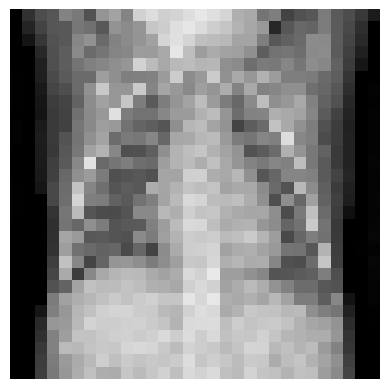

In [33]:
imagen_a_mostrar = imagenes[2]  # Selecciona la primera imagen, puedes cambiar el índice según la imagen que desees mostrar

imagen_reshaped = imagen_a_mostrar.reshape((30, 30, 3))
plt.imshow(imagen_reshaped)
plt.axis('off')
plt.show()

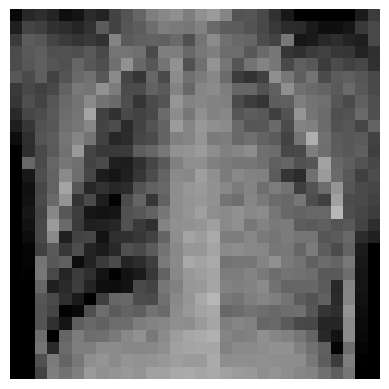

In [34]:
imagen_a_mostrar_pneumonia = imagenes_pneumonia[3]  # Selecciona la primera imagen, puedes cambiar el índice según la imagen que desees mostrar

imagen_reshaped = imagen_a_mostrar_pneumonia.reshape((30, 30, 3))
plt.imshow(imagen_reshaped)
plt.axis('off')
plt.show()

## Creacion del Dataset/Imput de entrenamiento del modelo

In [35]:
df=pd.DataFrame(dataset)
df_pneu=pd.DataFrame(dataset_pneumonia)

In [36]:
df['Etiqueta']=np.zeros(df.shape[0])
df_pneu['Etiqueta']=np.ones(df_pneu.shape[0])

In [37]:
df_train=pd.merge(df,df_pneu,how='outer')

In [38]:
df_train.shape[0]

5216

In [39]:
df_train.drop(columns=['Etiqueta'])

,0,1,2,3,4,5,6,7,8,9,...,2690,2691,2692,2693,2694,2695,2696,2697,2698,2699
0,19,19,19,69,69,69,92,92,92,108,...,11,27,27,27,33,33,33,38,38,38
1,30,30,30,48,48,48,105,105,105,114,...,142,49,49,49,0,0,0,0,0,0
2,0,0,0,49,49,49,77,77,77,86,...,138,68,68,68,0,0,0,0,0,0
3,49,49,49,76,76,76,102,102,102,115,...,146,66,66,66,2,2,2,11,11,11
4,87,87,87,58,58,58,40,40,40,47,...,107,102,102,102,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5211,0,0,0,46,46,46,71,71,71,120,...,159,88,88,88,0,0,0,0,0,0
5212,87,87,87,93,93,93,102,102,102,92,...,108,55,55,55,18,18,18,19,19,19
5213,28,28,28,0,0,0,40,40,40,62,...,148,135,135,135,104,104,104,46,46,46
5214,51,51,51,54,54,54,46,46,46,29,...,194,78,78,78,28,28,28,26,26,26


Definimos con este dataset creado nuestras variable de interes (y) y variables independientes (X)

In [41]:
X=df_train.drop(columns=['Etiqueta'])
y=df_train['Etiqueta']

## Tuning inicial del modelo con GridSearch

Con el fin de precisar cual seria la mejor configuracion posible o al menos la mejor de un grupo selecto (posibilidades finitas) se realizara un metodo de optimizacion con GridSeacrh el cual realizara la evaluacion de todas las posibles configuraciones que se le pidan y devolvera aquella con el mejor rendimiento

In [42]:
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10, verbose=0)

# Definir los parámetros a buscar
param_grid = {
    'neurons': [8, 16, 32],
    'layers': [1, 2, 3]
}

# Realizar la búsqueda de hiperparámetros con GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X.iloc[0:500,:], y[0:500])

# Mostrar los resultados
print("Mejores parámetros encontrados:", grid_result.best_params_)
print("Mejor precisión promedio:", grid_result.best_score_)

<ipython-input-42-81a5f395de99>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=10, verbose=0)


Mejores parámetros encontrados: {'layers': 1, 'neurons': 8}
Mejor precisión promedio: 1.0


Es importante especificar que este modelo al tener un volumen muy alto de datos y tener que evaluar diferentes configuraciones, se le brindara la opcion de hacerlo con un volumen de unicamente 500 datos escogidos randomicamente  y que nos permitan tener una idea de la mejor configuracion para entrenarlo con la totalidad o al menos una muestra mayor de datos

##Creacion del modelo

Creamos el modelo utilizando la version de nuestra funcion "Create model" del archivo funciones

In [43]:
model_use=create_model(32,2)

## Monitoreo del Modelo

En este caso se quiere ver la evolucion del modelo mientras este es entrenado, para ello se recopilan datos de "Accuracy" y la "Funcion de Perdida", con el paso de las epocas, para saber que tanto mejora el modelo con la configuracion dada por el tuning de hiperparametros

In [44]:
loss_per_epoch=[]
accuracy_per_epoch=[]
num_epochs=15

for epoch in range(num_epochs):
    # Entrenamiento por época
    history = model_use.fit(
      df_train.drop(columns=['Etiqueta']),df_train['Etiqueta'],epochs=1
    )

    # Almacenar la pérdida y la métrica (precisión en este caso) por época
    loss_per_epoch.append(history.history['loss'][0])
    accuracy_per_epoch.append(history.history['accuracy'][0])

163/163 [==============================] - 17s 106ms/step - loss: 0.1764 - accuracy: 0.9344


Graficamos las funciones de perdida con el paso de las epocas de entrenamiento del Modelo

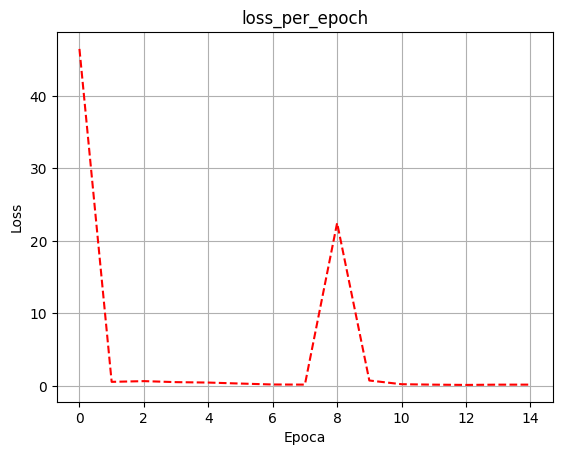

In [45]:
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.title('loss_per_epoch')
plt.grid(True)
plt.plot(loss_per_epoch,'r--')

Realizamos el mismo procedimiento para la funcion de accuracy, con el fin de ver que tann rapido aprende nuestro modelo con la configuracion asignada

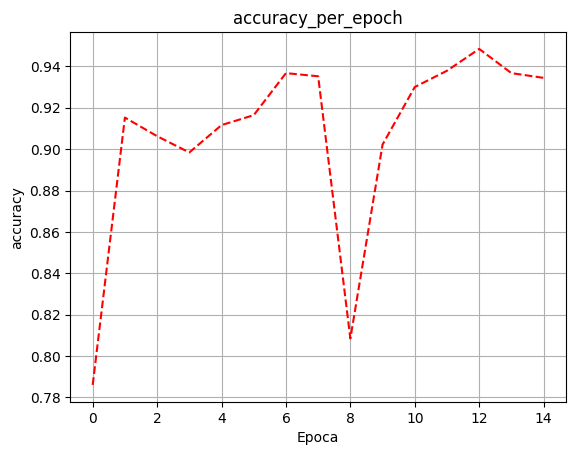

In [46]:
plt.xlabel('Epoca')
plt.ylabel('accuracy')
plt.title('accuracy_per_epoch')
plt.grid(True)
plt.plot(accuracy_per_epoch,'r--')

## Testing del Modelo

El proceso sigue una estructura similar, en donde primero se tiene que llamar a las funciones de lectura de imagenes para que el modelo pueda recibir el mismo tipo de imput con el que fue entrenado y a su vez con las mismas caracteristicas

In [47]:
dataset_test_norm,imagenes_test_norm=trans_imag_array('/content/drive/MyDrive/chest_xray/test/NORMAL')
dataset_test_pneu,imagenes_test_pneu=trans_imag_array('/content/drive/MyDrive/chest_xray/test/PNEUMONIA')

In [48]:
dataset_test_norm.shape[0],dataset_test_pneu.shape[0]

(234, 390)

In [ ]:
predicciones=model.predict(test_dataset,steps=math.ceil(num_test_examples/BATCHSIZE))